In [3]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2


In [64]:
import os
import logging 
import joblib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from scipy.interpolate import interp1d
from scipy.stats import zscore
from scipy.integrate import trapz

import algo_ecg.data
import algo_ecg.preprocessing
#import algo_ecg.model
from algo_ecg.feature_transformer import calculate_hrv_based_on_peak_intervals, \
calculate_hrv_based_on_peak_intervals3, generate_time_fre_domain_features, \
FindPeaksCustomTransformer, select_cols, AllFeatureCustomTransformer

import algo_ecg.feature_transformer

from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from PIL import Image
from IPython.display import display

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams['figure.figsize'] = [12, 8]

# Feature engineering
https://www.kubios.com/hrv-analysis-methods/
https://bartek-kulas.medium.com/working-with-ecg-heart-rate-data-on-python-7a45fa880d48
https://github.com/kulasbart/ECG-processing_HRV/blob/master/HRV_ECG_analysis.ipynb

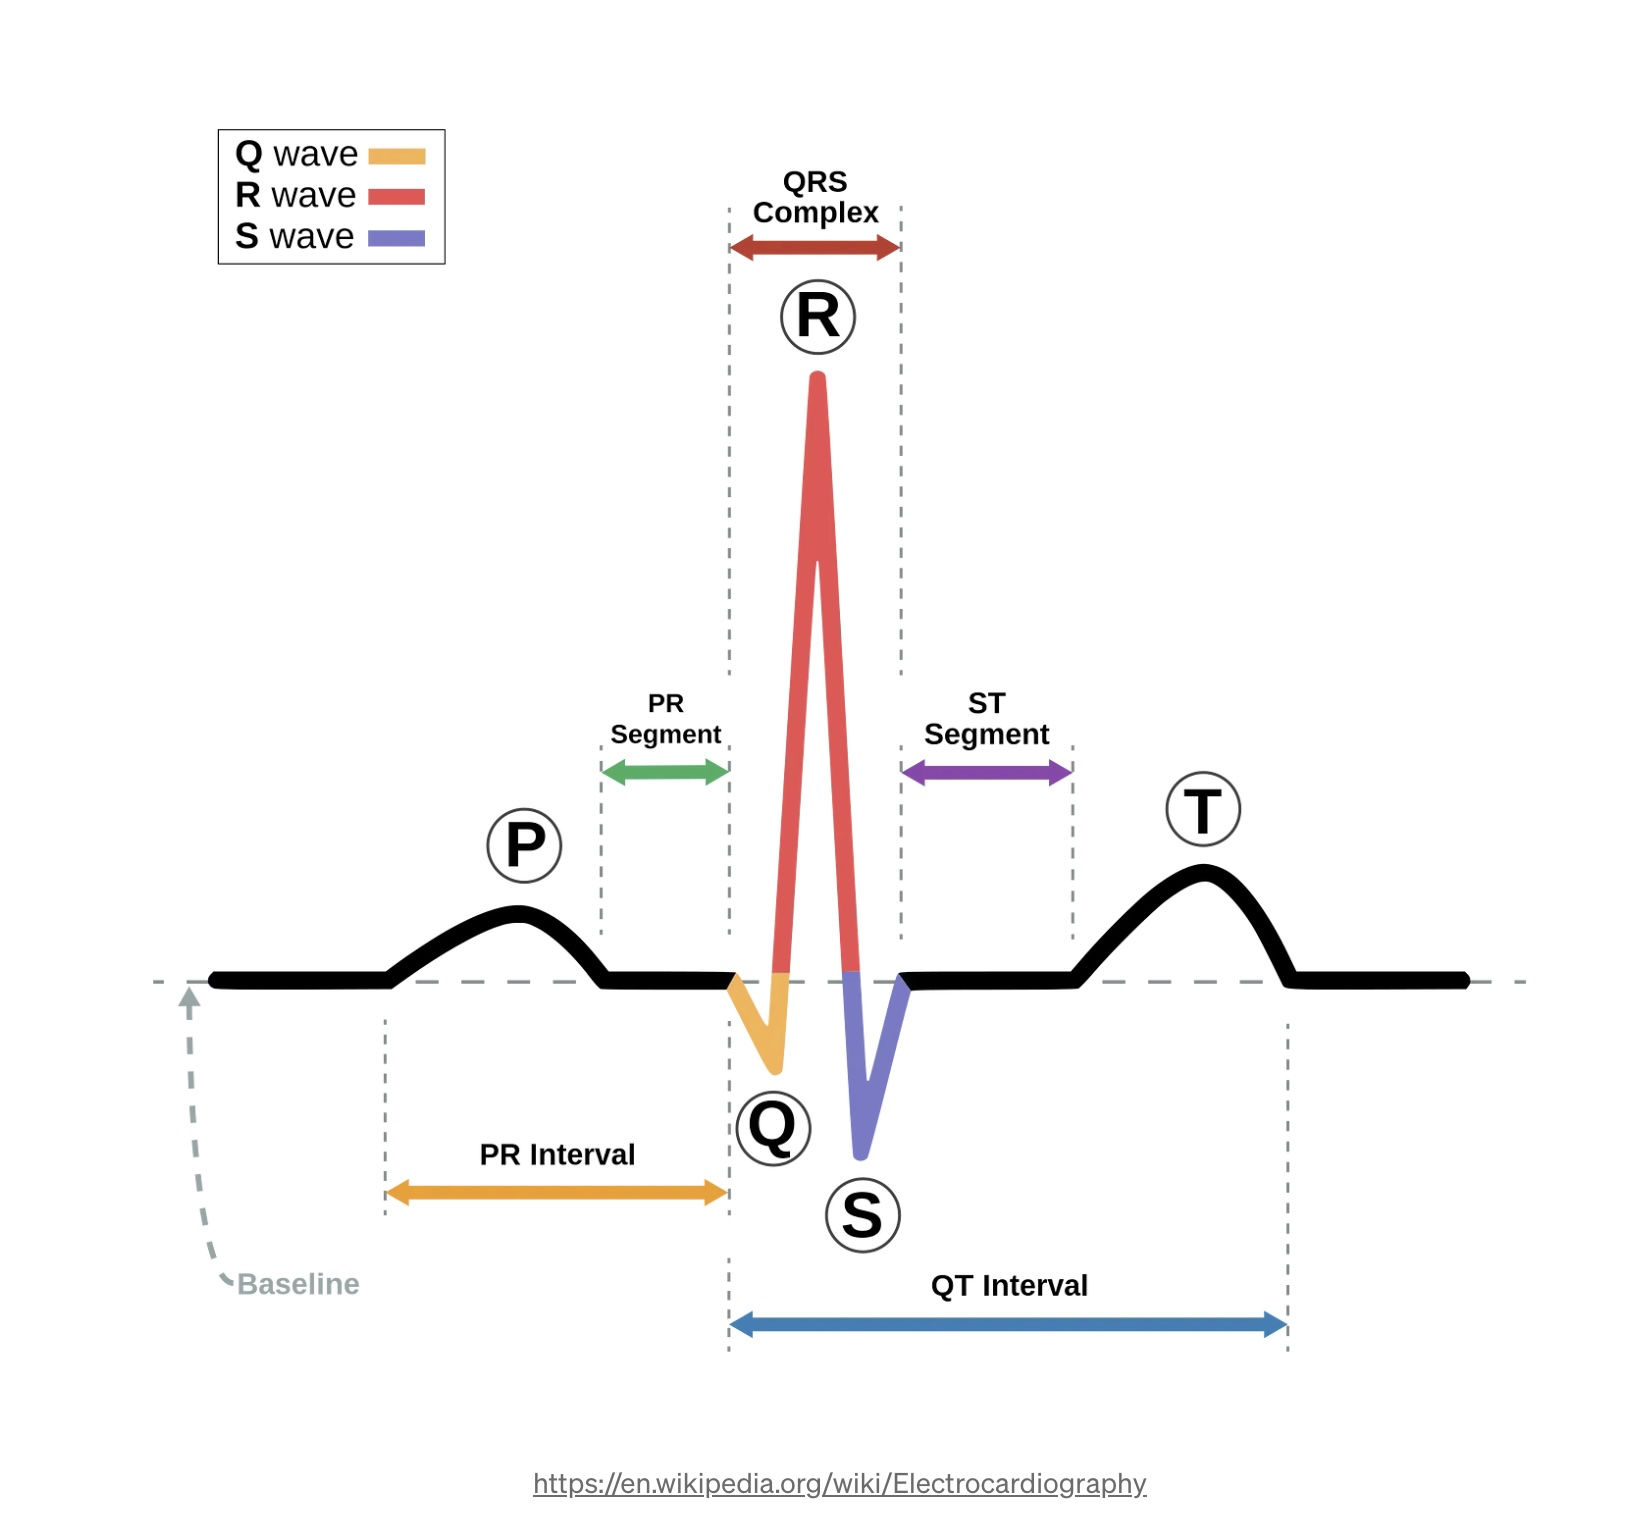

In [6]:
img = Image.open('../images/QRS.jpg')
display(img)

In [7]:
# Read in the data 
X_in, y = algo_ecg.data.import_physionet_data('../data', num_files_to_read=100)
#X_in, y = algo_ecg.data.import_physionet_data('../data')

In [8]:
X_in

array([[-127, -162, -197, ...,  -18,  -22,  -21],
       [ 128,  157,  189, ...,    0,    1,    2],
       [  56,   73,   85, ...,   13,   14,   15],
       ...,
       [   1,    0,    0, ..., -107, -106, -104],
       [ -69,  -93, -110, ...,  -40,  -23,   -6],
       [-232, -272, -312, ..., -129, -107,  -85]], dtype=int16)

In [9]:
X_in.shape

(72, 9000)

In [10]:
X = algo_ecg.preprocessing.preprocess(X_in)


DEBUG:root:
DEBUG:root:i=0: 37 outliers found
DEBUG:root:
DEBUG:root:i=1: 48 outliers found
DEBUG:root:
DEBUG:root:i=2: 6 outliers found
DEBUG:root:i=2: flipped values
DEBUG:root:
DEBUG:root:i=3: 45 outliers found
DEBUG:root:i=3: flipped values
DEBUG:root:
DEBUG:root:i=4: 99 outliers found
DEBUG:root:
DEBUG:root:i=5: 18 outliers found
DEBUG:root:
DEBUG:root:i=6: 44 outliers found
DEBUG:root:
DEBUG:root:i=7: 28 outliers found
DEBUG:root:
DEBUG:root:i=8: 53 outliers found
DEBUG:root:i=8: flipped values
DEBUG:root:
DEBUG:root:i=9: 19 outliers found
DEBUG:root:
DEBUG:root:i=10: 39 outliers found
DEBUG:root:
DEBUG:root:i=11: 119 outliers found
DEBUG:root:
DEBUG:root:i=13: 101 outliers found
DEBUG:root:
DEBUG:root:i=14: 92 outliers found
DEBUG:root:i=14: flipped values
DEBUG:root:
DEBUG:root:i=15: 61 outliers found
DEBUG:root:
DEBUG:root:i=16: 92 outliers found
DEBUG:root:
DEBUG:root:i=17: 13 outliers found
DEBUG:root:
DEBUG:root:i=18: 22 outliers found
DEBUG:root:
DEBUG:root:i=19: 99 outlie

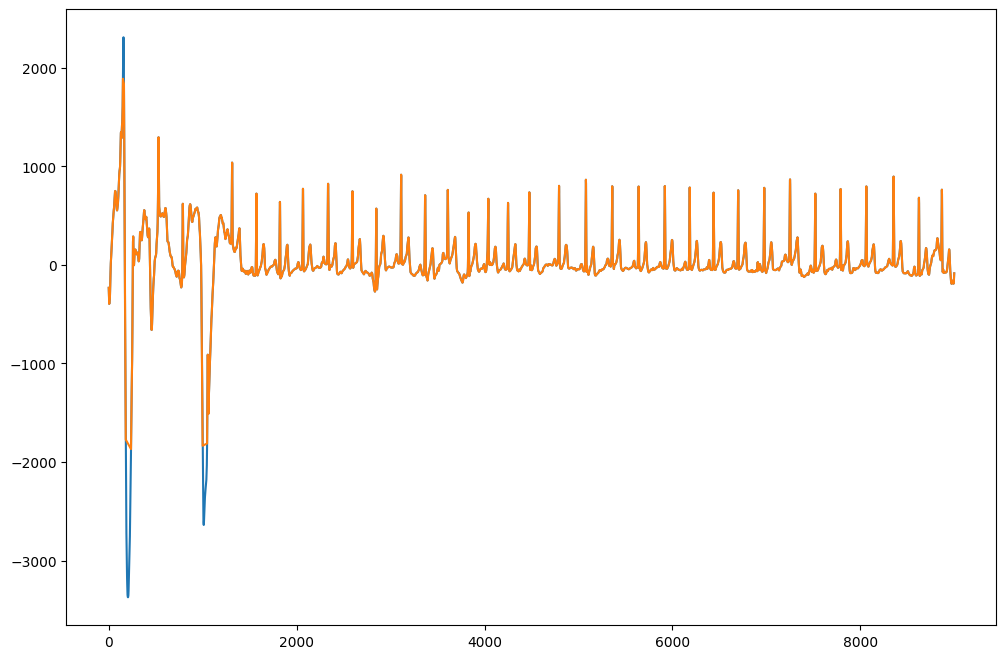

In [11]:
plt.plot(X_in[71])
plt.plot(X[71])


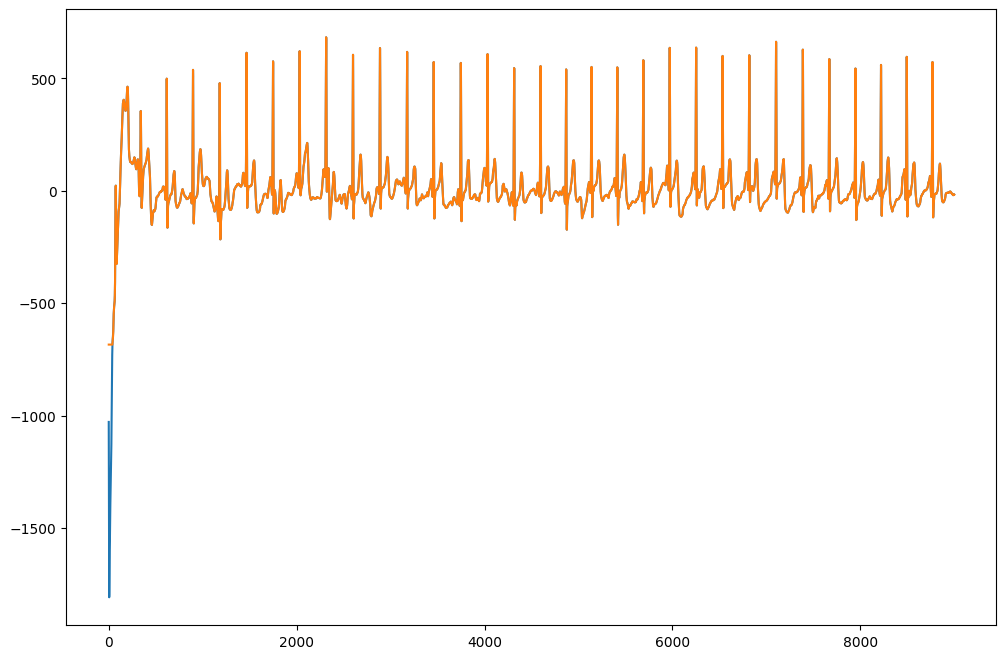

In [38]:

plt.plot(X_in[10])
plt.plot(X[10])

In [43]:
# linear spaced vector between 0.5 pi and 1.5 pi 
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# create sine filter for approximating QRS feature
peak_filter = np.sin(v)

# compute cross correlation between ecg and the sine filter
ecg_transformed = np.correlate(X_in[10], peak_filter, mode="same")


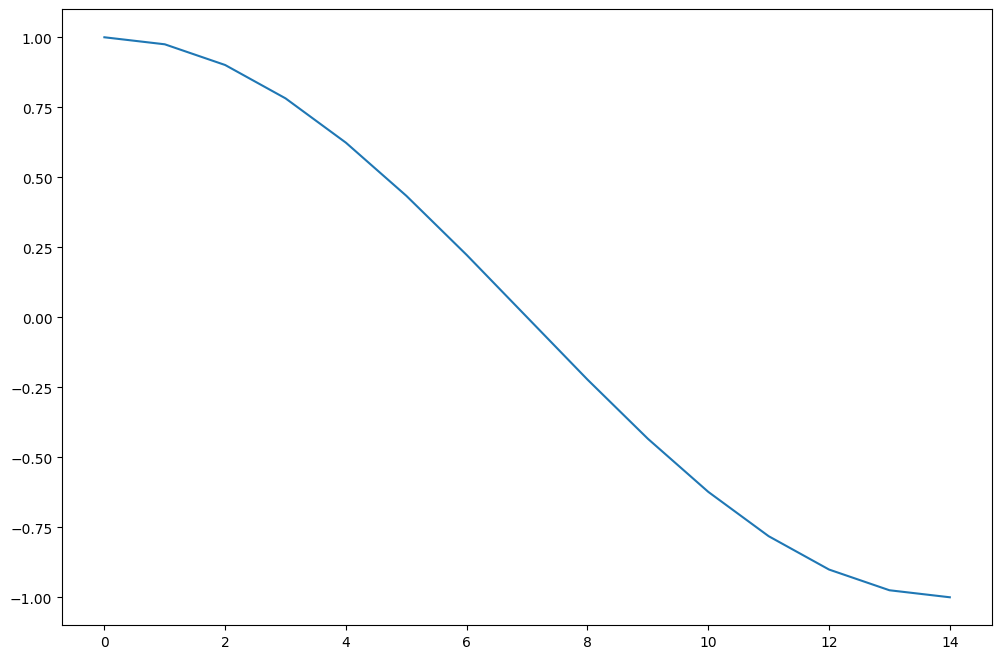

In [44]:
plt.plot(peak_filter)


In [45]:
len(ecg_transformed)

9000

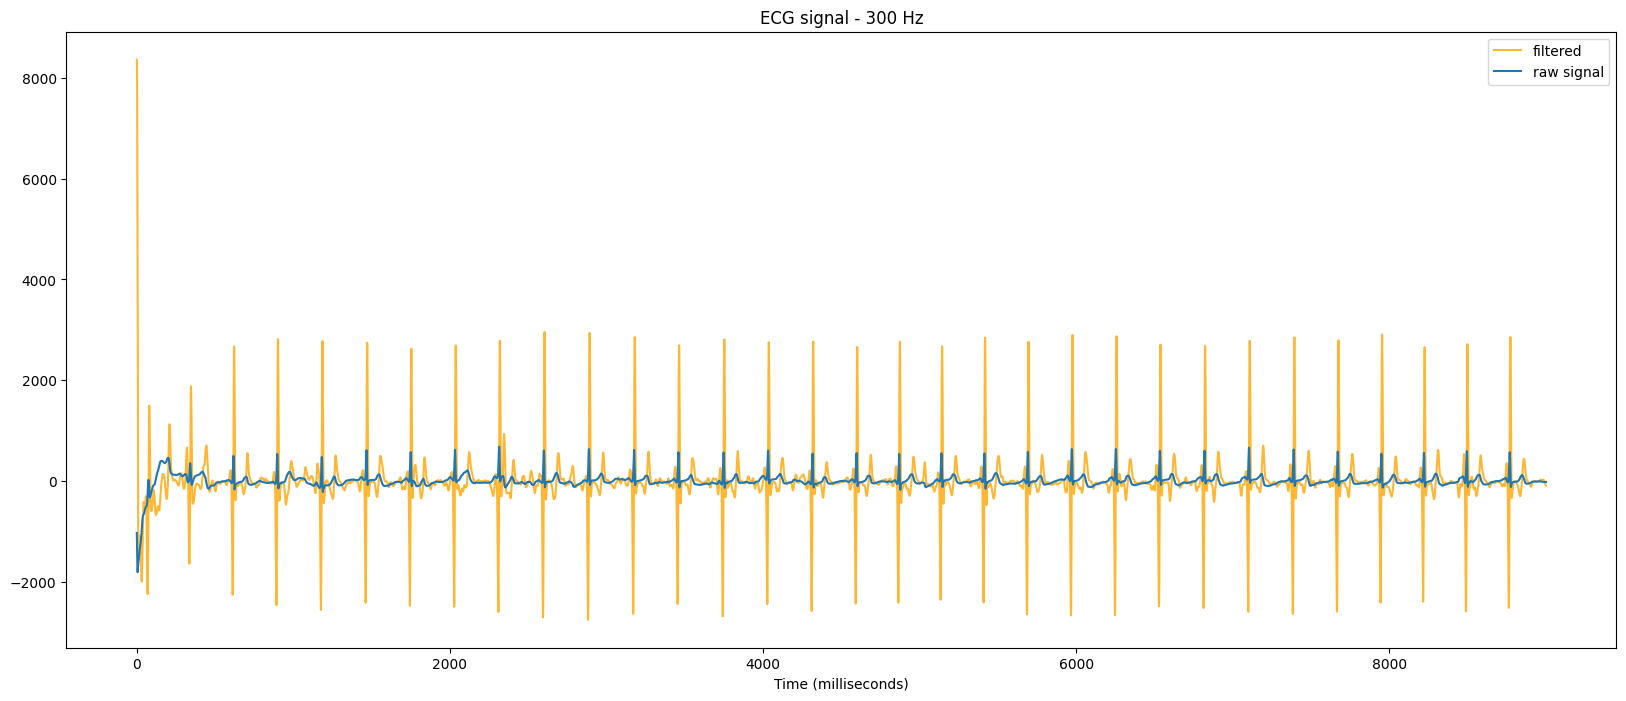

In [47]:
# and plot the raw + filtered signal
plt.figure(figsize=(20,8))
plt.title('ECG signal - 300 Hz')
plt.plot(ecg_transformed[0:9000], alpha = 0.8, c='orange')
plt.plot(X_in[10], alpha = 1)
plt.gca().legend(('filtered','raw signal'))
plt.xlabel('Time (milliseconds)')
plt.show()

The filtered signal (blue) is the computed cross-correlation between the raw signal (orange) and the sinewave filter. This is often referred to as a convolution. You can think of this as a measure of similarity between two signals. In our plot, we easily observe distinct peaks since the R-wave feature is prominent and easily separableâ€”for robust detection of more intricate features, especially those buried under background noise, we would likely require a more complex and specific transform algorithm

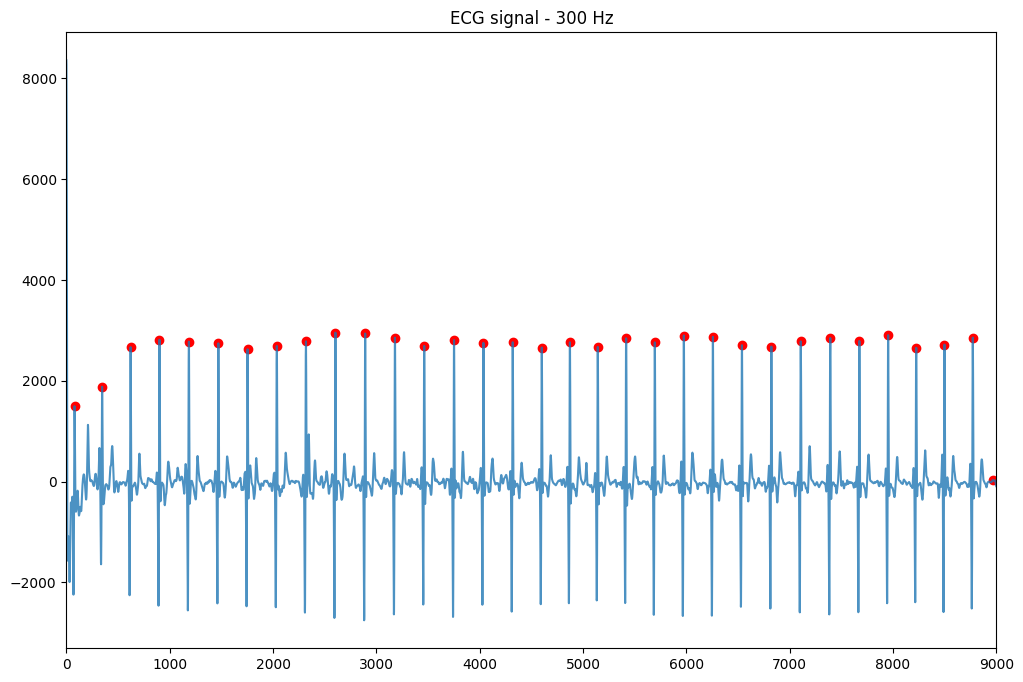

In [68]:
#Peak detection

rr_peaks, _ = find_peaks(ecg_transformed, distance=300*(30/60))
plt.plot(ecg_transformed, alpha = 0.8)
plt.scatter(rr_peaks, ecg_transformed[rr_peaks], color='red')
plt.xlim(0,9000)
plt.title("ECG signal - 300 Hz")
plt.show()


In [49]:
rr_peaks

array([  79,  346,  622,  901, 1186, 1471, 1754, 2037, 2319, 2604, 2892,
       3180, 3463, 3752, 4036, 4320, 4601, 4873, 5143, 5417, 5695, 5976,
       6257, 6538, 6823, 7107, 7393, 7674, 7953, 8225, 8498, 8772, 8964])

In [50]:
len(rr_peaks)

33

## Time domain features

In [51]:
SAMPLING_RATE = 300

In [52]:
# compute the diff along the time axis to end up with the R-R intervals
rr_ecg = np.diff(rr_peaks)

In [53]:
rr_ecg

array([267, 276, 279, 285, 285, 283, 283, 282, 285, 288, 288, 283, 289,
       284, 284, 281, 272, 270, 274, 278, 281, 281, 281, 285, 284, 286,
       281, 279, 272, 273, 274, 192])

In [54]:
#300 hz * 30 seconds = 9000 data points per 30 seconds 
#18000 is the length of one minutes
18000 / rr_ecg

array([67.41573034, 65.2173913 , 64.51612903, 63.15789474, 63.15789474,
       63.60424028, 63.60424028, 63.82978723, 63.15789474, 62.5       ,
       62.5       , 63.60424028, 62.28373702, 63.38028169, 63.38028169,
       64.0569395 , 66.17647059, 66.66666667, 65.69343066, 64.74820144,
       64.0569395 , 64.0569395 , 64.0569395 , 63.15789474, 63.38028169,
       62.93706294, 64.0569395 , 64.51612903, 66.17647059, 65.93406593,
       65.69343066, 93.75      ])

In [55]:
def timedomain(rr):
    results = {}
    sampling_rate = 300 
    rr_in_ms = (rr / sampling_rate) * 1000 
    
    hr = 60 * sampling_rate /rr
#    mean_hr = 60 * sampling_rate/np.mean(rr)

    # HRV metrics
    results['Mean RR (ms)'] = np.mean(rr_in_ms)
    results['STD RR/SDNN (ms)'] = np.std(rr_in_ms)
    results['Mean_HR_beats_per_min_kubio'] = 60 * sampling_rate/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)    
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr_in_ms))))
    results['NN50'] = np.sum(np.abs(np.diff(rr_in_ms)) > 50)*1
    results['pNN50 (%)'] = 100 * np.sum((np.abs(np.diff(rr_in_ms)) > 50)*1) / len(rr_in_ms)
    return results

timedomain(rr_ecg)

{'Mean RR (ms)': 925.5208333333333,
 'STD RR/SDNN (ms)': 54.44549628731675,
 'Mean_HR_beats_per_min_kubio': 64.82836240855374,
 'Mean HR (beats/min)': 65.13826705643545,
 'STD HR (beats/min)': 5.294406940754923,
 'Min HR (beats/min)': 62.28373702422145,
 'Max HR (beats/min)': 93.75,
 'RMSSD (ms)': 50.78240883017448,
 'NN50': 1,
 'pNN50 (%)': 3.125}

In [60]:
algo_ecg.feature_transformer.timedomain(rr_ecg)

{'Mean_RR_ms': 925.5208333333333,
 'STD_RR_ms': 54.44549628731675,
 'Mean_HR_beats_per_min_kubio': 64.82836240855374,
 'Mean_HR_beats_per_min': 65.13826705643545,
 'STD_HR_beats_per_min': 5.294406940754923,
 'Min_HR_beats_per_min': 62.28373702422145,
 'Max_HR_beats_per_min': 93.75,
 'RMSSD_ms': 50.78240883017448,
 'NN50': 1,
 'pNN50': 3.125,
 'NN70': 1,
 'pNN70': 3.125}

## Frequency domain features

In [16]:
# compute the diff along the time axis to end up with the R-R intervals
rr_ecg = np.diff(rr_peaks)

# fit function to the dataset
x_ecg = np.cumsum(rr_ecg)/300 
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

# sample rate for interpolation
fs = 4
steps = 1 / fs

# sample using the interpolation function
xx_ecg = np.arange(0, np.max(x_ecg), steps)
rr_interpolated_ecg = f_ecg(xx_ecg)


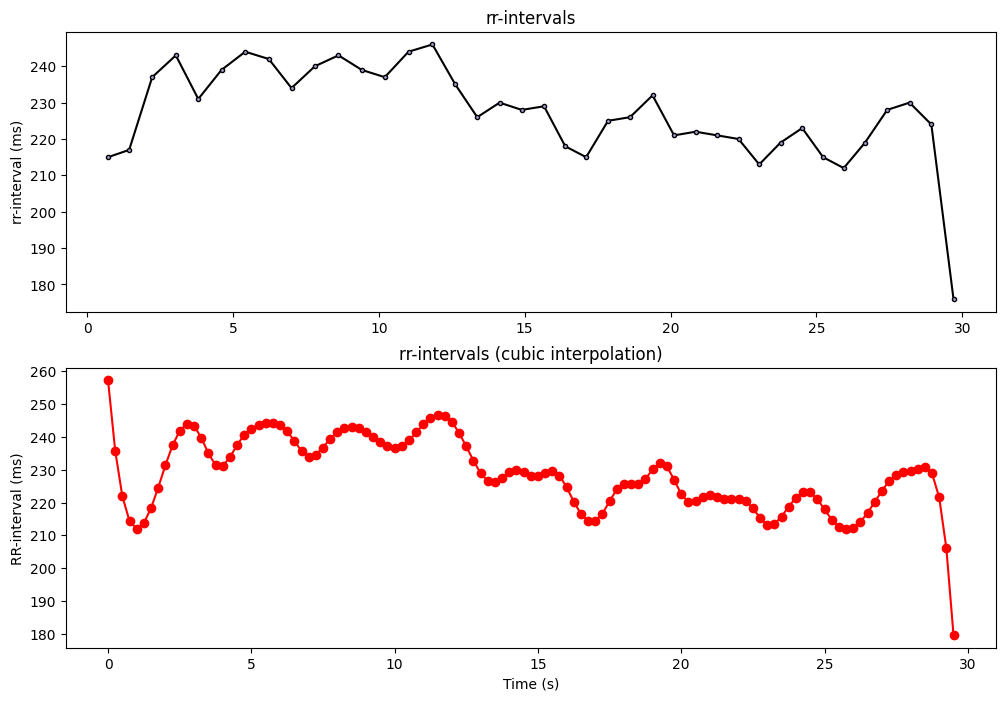

In [94]:
plt.subplot(211)
plt.title('rr-intervals')
plt.plot(x_ecg, rr_ecg, color='k', markerfacecolor='#A999D1',marker='o', markersize=3)
plt.ylabel('rr-interval (ms)')

plt.subplot(212)
plt.title('rr-intervals (cubic interpolation)')
plt.plot(xx_ecg, rr_interpolated_ecg, color='r',marker='o')
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')

plt.show()

In [18]:
# CLeaning & filtering
rr_ecg[np.abs(zscore(rr_ecg)) > 2] = np.median(rr_ecg)
x_ecg = np.cumsum(rr_ecg)/300
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

xx_ecg = np.arange(0, np.max(x_ecg), steps)
clean_rr_interpolated_ecg = f_ecg(xx_ecg)


In [19]:
len(rr_ecg)
rr_ecg[:5]

array([215, 217, 237, 243, 231])

In [20]:
len(rr_ecg)
rr_ecg[:5]

array([215, 217, 237, 243, 231])

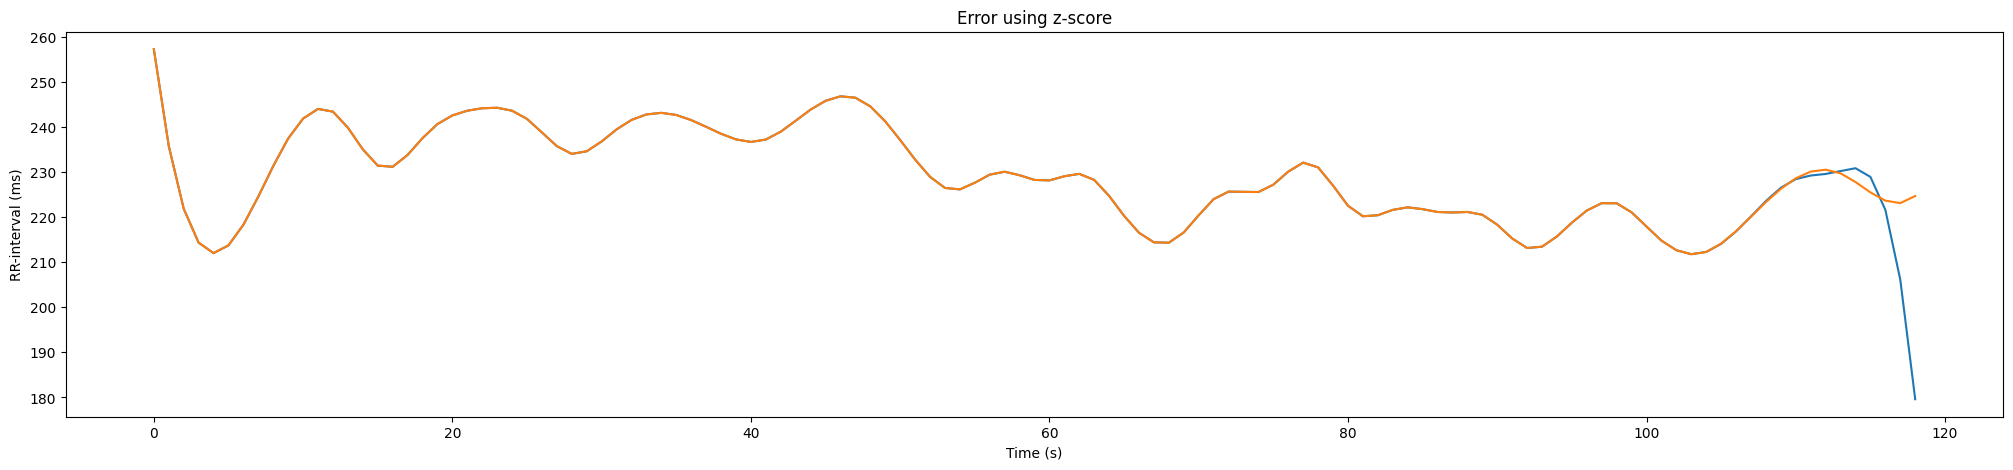

In [21]:
plt.figure(figsize=(25,5))
plt.title('Error using z-score')
plt.plot(rr_interpolated_ecg)
plt.plot(clean_rr_interpolated_ecg)
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')
plt.show()

In [22]:
rr_interpolated_ecg
len(rr_interpolated_ecg)
#len(clean_rr_interpolated_ecg)

119

In [95]:
fxx, pxx = welch(x=clean_rr_interpolated_ecg, fs=fs, nperseg=len(clean_rr_interpolated_ecg))
powerspectrum_f = interp1d(fxx, pxx, kind='cubic', fill_value= 'extrapolate')

In [96]:
clean_rr_interpolated_ecg

array([257.23372017, 235.76291533, 221.85087633, 214.32289414,
       212.00425973, 213.72026407, 218.29619813, 224.55735288,
       231.32901928, 237.43654717, 241.84986151, 243.99447075,
       243.38539765, 239.82817381, 235.01963384, 231.4136418 ,
       231.15582453, 233.77976401, 237.51062244, 240.63124249,
       242.54854665, 243.59753814, 244.13690334, 244.25289978,
       243.5941817 , 241.77014521, 238.76984641, 235.73270505,
       234.015192  , 234.59142652, 236.77868697, 239.44557232,
       241.54984513, 242.76780039, 243.12263288, 242.64686239,
       241.51292843, 240.0215337 , 238.47880265, 237.22794385,
       236.6676388 , 237.19999848, 238.94508638, 241.36964463,
       243.84816744, 245.79138861, 246.78718549, 246.47747784,
       244.54839744, 241.22556802, 237.09526828, 232.75629034,
       228.93140185, 226.46104282, 226.13900726, 227.61543815,
       229.41654534, 230.06036786, 229.28161283, 228.23803452,
       228.13890324, 229.05609758, 229.58398414, 228.23

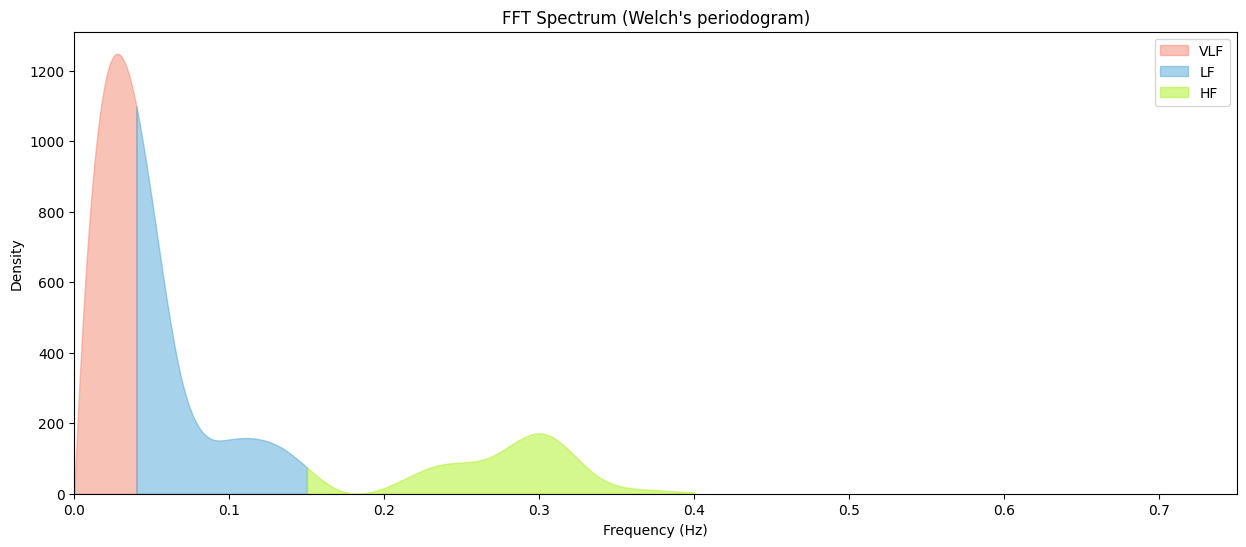

In [25]:
plt.figure(figsize=(15,6))
plt.title("FFT Spectrum (Welch's periodogram)")

# setup frequency bands for plotting
x_VLF = np.linspace(0, 0.04, 100)
x_LF = np.linspace(0.04, 0.15, 100)
x_HF = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_VLF, powerspectrum_f(x_VLF), alpha=0.5, color="#F5866F", label="VLF")
plt.gca().fill_between(x_LF, powerspectrum_f(x_LF), alpha=0.5, color="#51A6D8", label="LF")
plt.gca().fill_between(x_HF, powerspectrum_f(x_HF), alpha=0.5, color="#ABF31F", label="HF")

plt.gca().set_xlim(0, 0.75)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")

plt.legend()
plt.show()

In [29]:
def freq_domain(fxx, pxx):

    #frequency bands: very low frequency (VLF), low frequency (LF), high frequency (HF) 
    cond_VLF = (fxx >= 0) & (fxx < 0.04)
    cond_LF = (fxx >= 0.04) & (fxx < 0.15)
    cond_HF = (fxx >= 0.15) & (fxx < 0.4)

    #calculate power in each band by integrating the spectral density using trapezoidal rule 
    VLF = trapz(pxx[cond_VLF], fxx[cond_VLF])
    LF = trapz(pxx[cond_LF], fxx[cond_LF])
    HF = trapz(pxx[cond_HF], fxx[cond_HF])

    #total power sum
    total_power = VLF + LF + HF

    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_VLF], fxx[cond_VLF])
    lf = trapz(pxx[cond_LF], fxx[cond_LF])
    hf = trapz(pxx[cond_HF], fxx[cond_HF])


    #peaks (Hz) in each band
    peak_VLF = fxx[cond_VLF][np.argmax(pxx[cond_VLF])]
    peak_LF = fxx[cond_LF][np.argmax(pxx[cond_LF])]
    peak_HF = fxx[cond_HF][np.argmax(pxx[cond_HF])]

    #fractions
    LF_nu = 100 * lf / (lf + hf)
    HF_nu = 100 * hf / (lf + hf)

    results = {}
    results['Power VLF (ms2)'] = VLF
    results['Power LF (ms2)'] = LF
    results['Power HF (ms2)'] = HF   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (LF/HF)
    results['Peak VLF (Hz)'] = peak_VLF
    results['Peak LF (Hz)'] = peak_LF
    results['Peak HF (Hz)'] = peak_HF

    results['Fraction LF (nu)'] = LF_nu
    results['Fraction HF (nu)'] = HF_nu

    return results


In [30]:
freq_domain(fxx, pxx)

{'Power VLF (ms2)': 20.480595855159667,
 'Power LF (ms2)': 13.422987140949282,
 'Power HF (ms2)': 14.927637805734738,
 'Power Total (ms2)': 48.83122080184369,
 'LF/HF': 0.8992036995828357,
 'Peak VLF (Hz)': 0.03361344537815126,
 'Peak LF (Hz)': 0.06722689075630252,
 'Peak HF (Hz)': 0.3025210084033613,
 'Fraction LF (nu)': 47.346353620748935,
 'Fraction HF (nu)': 52.65364637925106}